In [90]:
import torch
import numpy as np
from six.moves import cPickle as pickle
from torch.utils.data import DataLoader
import torch.nn.utils.rnn as rnn
from coatt.cocoqa_dataset import CocoQADataset
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

In [1]:
%pip install torchvision --user

  Using cached https://files.pythonhosted.org/packages/9b/e2/2b1f88a363ae37b2ba52cfb785ddfb3dd5f7e7ec9459e96fd8299b84ae39/torchvision-0.4.2-cp36-cp36m-manylinux1_x86_64.whl
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
with open('./data/cocoqa/q2i.pkl', 'rb') as f:
    q2i = pickle.load(f)
with open('./data/cocoqa/a2i.pkl', 'rb') as f:
    a2i = pickle.load(f)
with open('./data/cocoqa/i2a.pkl', 'rb') as f:
    i2a = pickle.load(f)

In [3]:
i2q = sorted(list(q2i.items()), key=lambda x: x[1])
i2q[:10]

[('UNK', 0),
 ('<sos>', 1),
 ('<eos>', 2),
 ('the', 3),
 ('what', 4),
 ('is', 5),
 ('a', 6),
 ('of', 7),
 ('on', 8),
 ('in', 9)]

In [4]:
tr_img_names = np.load('./data/cocoqa/tr_img_names.npy', encoding='latin1').tolist()
va_img_names = np.load('./data/cocoqa/va_img_names.npy', encoding='latin1').tolist()

In [5]:
tr_img_names[0]

'COCO_train2014_000000397899.jpg'

In [39]:
def collate_lines(seq_list):
    imgT, quesT, gT = zip(*seq_list)
    lens = [len(ques) for ques in quesT]
    seq_order = sorted(range(len(lens)), key=lens.__getitem__, reverse=True)
    imgT = torch.stack([imgT[i] for i in seq_order])
    quesT = [quesT[i] for i in seq_order]
    gT = torch.stack([gT[i] for i in seq_order])
    return imgT, quesT, gT

In [115]:
train_image_dir = "/projectnb/statnlp/shawnlin/dataset/mscoco_vqa_2014/train2014/"
train_question_path = "./data/cocoqa/tr_ques_ids.npy"
train_annotation_path = "/projectnb/statnlp/shawnlin/dataset/cocoqa_2015/train/answers.txt"

train_dataset = CocoQADataset(image_dir=train_image_dir,
                                       question_id_file=train_question_path,
                                       answer_text_file=train_annotation_path,
                                       collate=True,
                                       image_names=tr_img_names,
                                       q2i=q2i,
                                       a2i=a2i,
                                       i2a=i2a,
                                       method="coattention")

test_image_dir = "/projectnb/statnlp/shawnlin/dataset/mscoco_vqa_2014/val2014/"
test_question_path = "./data/cocoqa/va_ques_ids.npy"
test_annotation_path = "/projectnb/statnlp/shawnlin/dataset/cocoqa_2015/test/answers.txt"

val_dataset = CocoQADataset(image_dir=test_image_dir,
                                     question_id_file=test_question_path,
                                     answer_text_file=test_annotation_path,
                                     collate=True,
                                     image_names=va_img_names,
                                     q2i=q2i,
                                     a2i=a2i,
                                     i2a=i2a,
                                     method="coattention")

train_dataset_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=1, collate_fn=collate_lines)
val_dataset_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=1, collate_fn=collate_lines)

coattention
coattention


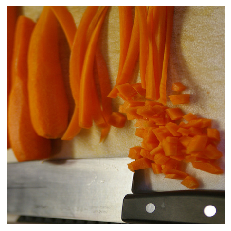

<sos> what are sitting on the counter in different stages of cutting with a knife <eos>
ans: carrots


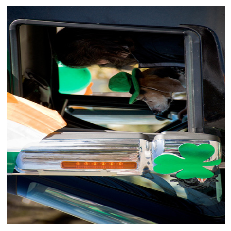

<sos> where does the person sit next to a top with a hat on <eos>
ans: car


In [68]:
for batch_id, (imgT, quesT, gT) in enumerate(val_dataset_loader):
    if batch_id > 1:
        break
    plt.imshow(np.swapaxes(imgT[0], 0, 2))
    plt.axis("off")
    plt.show()
    ques_str = [i2q[q][0] for q in quesT[0].numpy()]
    print(" ".join(ques_str))
    ans_str = i2a[gT[0].numpy()[0]]
    print("ans:", ans_str)
    
#     input()

In [108]:
from coatt.coattention_net import CoattentionNet

device = torch.device("cuda")
model = CoattentionNet(len(q2i), 512, training=False).float()
model.to(device=device)
checkpoint = torch.load("chk_coattention/checkpoint_220.pth.tar", map_location=device)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [109]:
model.eval()

CoattentionNet(
  (embed): Embedding(10158, 512)
  (unigram_conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
  (bigram_conv): Conv1d(512, 512, kernel_size=(2,), stride=(1,), padding=(1,), dilation=(2,))
  (trigram_conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
  (max_pool): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(512, 512, num_layers=3, dropout=0.5)
  (tanh): Tanh()
  (W_w): Linear(in_features=512, out_features=512, bias=True)
  (W_p): Linear(in_features=1024, out_features=512, bias=True)
  (W_s): Linear(in_features=1024, out_features=512, bias=True)
  (fc): Linear(in_features=512, out_features=512, bias=True)
)

In [99]:
model.tanh

Tanh()

In [106]:
from torchvision import models
import torch.nn as nn
img_enc = models.resnet18(pretrained=True)
modules = list(img_enc.children())[:-2]
img_enc = nn.Sequential(*modules)
for params in img_enc.parameters():
    params.requires_grad = False
# if device == "cuda":
img_enc = img_enc.cuda()
img_enc.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [116]:
model.eval()

tot_correct = 0.
tot_sample = 0
with torch.no_grad():
    for batch_id, (imgT, quesT, gT) in enumerate(tqdm(val_dataset_loader)):
#         if batch_id > 100:
#             break
#         plt.imshow(np.swapaxes(imgT[0], 0, 2))
#         plt.axis("off")
#         plt.show()    
#         ques_str = [i2q[q][0] for q in quesT[0].numpy()]
#         print(" ".join(ques_str))
#         ans_str = i2a[gT[0].numpy()[0]]
#         print("ans:", ans_str)

        # Run prediction
        quesT = rnn.pack_sequence(quesT)
        imgT = imgT.to(device)
        imgT = img_enc(imgT)
        imgT = imgT.view(imgT.size(0), imgT.size(1), -1)

        imgT, quesT, gT = imgT.to(device), quesT.to(device), gT.to(device)
        gT = torch.squeeze(gT)
        pd_ans = model(imgT, quesT)
        pd_ans_idx = np.argmax(pd_ans.cpu().numpy(), axis=1)
#         print("pred_ans:", i2a[pd_ans_idx[0]])
        tot_correct += np.sum(gT.cpu().numpy() == pd_ans_idx)
        tot_sample += gT.shape[0]

#         input()
print(tot_correct / tot_sample)





  0%|          | 0/9737 [00:00<?, ?it/s]



  0%|          | 1/9737 [00:00<34:03,  4.76it/s]



  0%|          | 3/9737 [00:00<26:49,  6.05it/s]



  0%|          | 5/9737 [00:00<21:50,  7.43it/s]



  0%|          | 7/9737 [00:00<18:18,  8.86it/s]



  0%|          | 9/9737 [00:00<15:49, 10.25it/s]



  0%|          | 11/9737 [00:00<14:01, 11.56it/s]



  0%|          | 13/9737 [00:00<12:39, 12.80it/s]



  0%|          | 15/9737 [00:01<11:42, 13.84it/s]



  0%|          | 17/9737 [00:01<11:01, 14.70it/s]



  0%|          | 19/9737 [00:01<10:33, 15.35it/s]



  0%|          | 21/9737 [00:01<10:32, 15.35it/s]



  0%|          | 23/9737 [00:01<10:19, 15.68it/s]



  0%|          | 25/9737 [00:01<10:13, 15.83it/s]



  0%|          | 27/9737 [00:01<10:01, 16.13it/s]



  0%|          | 29/9737 [00:01<09:51, 16.42it/s]



  0%|          | 31/9737 [00:02<09:51, 16.42it/s]



  0%|          | 33/9737 [00:02<09:43, 16.64it/s]



  0%|          | 35/9737 [00:02<09:33, 16.91it/s]



  0

  3%|▎         | 249/9737 [00:14<09:18, 16.98it/s]



  3%|▎         | 251/9737 [00:14<09:06, 17.35it/s]



  3%|▎         | 253/9737 [00:15<09:04, 17.43it/s]



  3%|▎         | 255/9737 [00:15<08:58, 17.61it/s]



  3%|▎         | 257/9737 [00:15<08:47, 17.96it/s]



  3%|▎         | 259/9737 [00:15<08:53, 17.75it/s]



  3%|▎         | 261/9737 [00:15<08:55, 17.71it/s]



  3%|▎         | 263/9737 [00:15<08:56, 17.67it/s]



  3%|▎         | 265/9737 [00:15<09:07, 17.30it/s]



  3%|▎         | 267/9737 [00:15<09:11, 17.16it/s]



  3%|▎         | 269/9737 [00:15<09:06, 17.33it/s]



  3%|▎         | 271/9737 [00:16<08:54, 17.72it/s]



  3%|▎         | 273/9737 [00:16<08:44, 18.05it/s]



  3%|▎         | 275/9737 [00:16<08:41, 18.14it/s]



  3%|▎         | 277/9737 [00:16<09:09, 17.21it/s]



  3%|▎         | 279/9737 [00:16<09:19, 16.91it/s]



  3%|▎         | 281/9737 [00:16<09:05, 17.32it/s]



  3%|▎         | 283/9737 [00:16<09:19, 16.90it/s]



  3%|▎         | 285/9737 [0

  5%|▌         | 498/9737 [00:29<09:34, 16.07it/s]



  5%|▌         | 500/9737 [00:29<09:20, 16.48it/s]



  5%|▌         | 502/9737 [00:29<09:14, 16.66it/s]



  5%|▌         | 504/9737 [00:29<08:58, 17.15it/s]



  5%|▌         | 506/9737 [00:29<10:15, 14.99it/s]



  5%|▌         | 508/9737 [00:30<13:04, 11.76it/s]



  5%|▌         | 510/9737 [00:30<12:03, 12.75it/s]



  5%|▌         | 512/9737 [00:30<11:03, 13.90it/s]



  5%|▌         | 514/9737 [00:30<10:11, 15.08it/s]



  5%|▌         | 516/9737 [00:30<09:43, 15.82it/s]



  5%|▌         | 518/9737 [00:30<09:22, 16.40it/s]



  5%|▌         | 520/9737 [00:30<09:10, 16.75it/s]



  5%|▌         | 522/9737 [00:30<09:25, 16.30it/s]



  5%|▌         | 524/9737 [00:31<09:28, 16.20it/s]



  5%|▌         | 526/9737 [00:31<09:29, 16.18it/s]



  5%|▌         | 528/9737 [00:31<09:29, 16.18it/s]



  5%|▌         | 530/9737 [00:31<09:01, 17.00it/s]



  5%|▌         | 532/9737 [00:31<09:10, 16.71it/s]



  5%|▌         | 534/9737 [0

  8%|▊         | 746/9737 [00:44<08:31, 17.57it/s]



  8%|▊         | 748/9737 [00:44<08:34, 17.46it/s]



  8%|▊         | 750/9737 [00:44<08:33, 17.49it/s]



  8%|▊         | 752/9737 [00:44<08:41, 17.24it/s]



  8%|▊         | 754/9737 [00:45<08:51, 16.90it/s]



  8%|▊         | 756/9737 [00:45<08:39, 17.27it/s]



  8%|▊         | 758/9737 [00:45<08:40, 17.25it/s]



  8%|▊         | 760/9737 [00:45<08:51, 16.89it/s]



  8%|▊         | 762/9737 [00:45<08:44, 17.10it/s]



  8%|▊         | 764/9737 [00:45<08:37, 17.33it/s]



  8%|▊         | 766/9737 [00:45<08:37, 17.33it/s]



  8%|▊         | 768/9737 [00:45<08:35, 17.40it/s]



  8%|▊         | 770/9737 [00:46<08:41, 17.18it/s]



  8%|▊         | 772/9737 [00:46<08:40, 17.23it/s]



  8%|▊         | 774/9737 [00:46<08:36, 17.35it/s]



  8%|▊         | 776/9737 [00:46<08:35, 17.38it/s]



  8%|▊         | 778/9737 [00:46<08:33, 17.46it/s]



  8%|▊         | 780/9737 [00:46<08:32, 17.47it/s]



  8%|▊         | 782/9737 [0

 10%|█         | 996/9737 [00:59<08:58, 16.22it/s]



 10%|█         | 998/9737 [00:59<09:01, 16.15it/s]



 10%|█         | 1000/9737 [00:59<08:49, 16.52it/s]



 10%|█         | 1002/9737 [00:59<08:41, 16.76it/s]



 10%|█         | 1004/9737 [00:59<08:21, 17.41it/s]



 10%|█         | 1006/9737 [00:59<08:30, 17.10it/s]



 10%|█         | 1008/9737 [00:59<08:51, 16.42it/s]



 10%|█         | 1010/9737 [01:00<08:37, 16.87it/s]



 10%|█         | 1012/9737 [01:00<08:49, 16.49it/s]



 10%|█         | 1014/9737 [01:00<08:49, 16.48it/s]



 10%|█         | 1016/9737 [01:00<08:39, 16.79it/s]



 10%|█         | 1018/9737 [01:00<08:29, 17.11it/s]



 10%|█         | 1020/9737 [01:00<08:37, 16.86it/s]



 10%|█         | 1022/9737 [01:00<08:34, 16.94it/s]



 11%|█         | 1024/9737 [01:00<08:41, 16.70it/s]



 11%|█         | 1026/9737 [01:00<08:38, 16.80it/s]



 11%|█         | 1028/9737 [01:01<08:26, 17.20it/s]



 11%|█         | 1030/9737 [01:01<08:17, 17.52it/s]



 11%|█      

 13%|█▎        | 1240/9737 [01:14<08:56, 15.85it/s]



 13%|█▎        | 1242/9737 [01:14<09:56, 14.23it/s]



 13%|█▎        | 1244/9737 [01:14<09:27, 14.97it/s]



 13%|█▎        | 1246/9737 [01:14<08:53, 15.93it/s]



 13%|█▎        | 1248/9737 [01:15<08:34, 16.51it/s]



 13%|█▎        | 1250/9737 [01:15<08:32, 16.56it/s]



 13%|█▎        | 1252/9737 [01:15<08:33, 16.54it/s]



 13%|█▎        | 1254/9737 [01:15<08:33, 16.52it/s]



 13%|█▎        | 1256/9737 [01:15<08:32, 16.55it/s]



 13%|█▎        | 1258/9737 [01:15<08:23, 16.83it/s]



 13%|█▎        | 1260/9737 [01:15<08:31, 16.57it/s]



 13%|█▎        | 1262/9737 [01:15<08:06, 17.40it/s]



 13%|█▎        | 1264/9737 [01:15<08:11, 17.24it/s]



 13%|█▎        | 1266/9737 [01:16<08:05, 17.44it/s]



 13%|█▎        | 1268/9737 [01:16<08:10, 17.28it/s]



 13%|█▎        | 1270/9737 [01:16<08:05, 17.44it/s]



 13%|█▎        | 1272/9737 [01:16<08:03, 17.51it/s]



 13%|█▎        | 1274/9737 [01:16<08:04, 17.48it/s]



 13%|█▎   

 15%|█▌        | 1485/9737 [01:29<10:07, 13.57it/s]



 15%|█▌        | 1487/9737 [01:29<09:30, 14.46it/s]



 15%|█▌        | 1489/9737 [01:29<08:59, 15.28it/s]



 15%|█▌        | 1491/9737 [01:29<08:35, 16.00it/s]



 15%|█▌        | 1493/9737 [01:29<08:23, 16.37it/s]



 15%|█▌        | 1495/9737 [01:29<08:15, 16.65it/s]



 15%|█▌        | 1497/9737 [01:29<08:08, 16.85it/s]



 15%|█▌        | 1499/9737 [01:30<08:07, 16.89it/s]



 15%|█▌        | 1501/9737 [01:30<08:10, 16.79it/s]



 15%|█▌        | 1503/9737 [01:30<08:06, 16.91it/s]



 15%|█▌        | 1505/9737 [01:30<08:02, 17.04it/s]



 15%|█▌        | 1507/9737 [01:30<07:52, 17.41it/s]



 15%|█▌        | 1509/9737 [01:30<07:56, 17.29it/s]



 16%|█▌        | 1511/9737 [01:30<07:56, 17.25it/s]



 16%|█▌        | 1513/9737 [01:30<08:05, 16.94it/s]



 16%|█▌        | 1515/9737 [01:30<07:54, 17.32it/s]



 16%|█▌        | 1517/9737 [01:31<07:49, 17.51it/s]



 16%|█▌        | 1519/9737 [01:31<07:46, 17.60it/s]



 16%|█▌   

 17%|█▋        | 1669/9737 [01:46<16:52,  7.97it/s]



 17%|█▋        | 1671/9737 [01:46<16:10,  8.31it/s]



 17%|█▋        | 1673/9737 [01:46<15:18,  8.78it/s]



 17%|█▋        | 1674/9737 [01:46<16:04,  8.36it/s]



 17%|█▋        | 1675/9737 [01:46<17:16,  7.78it/s]



 17%|█▋        | 1676/9737 [01:46<17:45,  7.56it/s]



 17%|█▋        | 1677/9737 [01:47<17:34,  7.65it/s]



 17%|█▋        | 1679/9737 [01:47<16:25,  8.17it/s]



 17%|█▋        | 1680/9737 [01:47<16:09,  8.31it/s]



 17%|█▋        | 1681/9737 [01:47<18:14,  7.36it/s]



 17%|█▋        | 1682/9737 [01:47<17:33,  7.65it/s]



 17%|█▋        | 1683/9737 [01:47<17:38,  7.61it/s]



 17%|█▋        | 1684/9737 [01:47<18:07,  7.40it/s]



 17%|█▋        | 1685/9737 [01:48<16:50,  7.96it/s]



 17%|█▋        | 1686/9737 [01:48<17:01,  7.88it/s]



 17%|█▋        | 1687/9737 [01:48<16:39,  8.06it/s]



 17%|█▋        | 1688/9737 [01:48<16:42,  8.03it/s]



 17%|█▋        | 1690/9737 [01:48<16:02,  8.36it/s]



 17%|█▋   

 19%|█▊        | 1807/9737 [02:03<18:30,  7.14it/s]



 19%|█▊        | 1808/9737 [02:03<18:32,  7.13it/s]



 19%|█▊        | 1809/9737 [02:03<17:43,  7.45it/s]



 19%|█▊        | 1810/9737 [02:03<16:37,  7.94it/s]



 19%|█▊        | 1811/9737 [02:03<15:55,  8.30it/s]



 19%|█▊        | 1812/9737 [02:04<17:06,  7.72it/s]



 19%|█▊        | 1814/9737 [02:04<15:06,  8.74it/s]



 19%|█▊        | 1816/9737 [02:04<14:49,  8.90it/s]



 19%|█▊        | 1817/9737 [02:04<16:32,  7.98it/s]



 19%|█▊        | 1818/9737 [02:04<17:00,  7.76it/s]



 19%|█▊        | 1819/9737 [02:04<16:57,  7.78it/s]



 19%|█▊        | 1820/9737 [02:04<15:55,  8.29it/s]



 19%|█▊        | 1821/9737 [02:05<15:27,  8.53it/s]



 19%|█▊        | 1822/9737 [02:05<16:16,  8.10it/s]



 19%|█▊        | 1823/9737 [02:05<16:29,  8.00it/s]



 19%|█▊        | 1824/9737 [02:05<15:36,  8.45it/s]



 19%|█▊        | 1825/9737 [02:05<15:33,  8.48it/s]



 19%|█▉        | 1826/9737 [02:05<17:17,  7.63it/s]



 19%|█▉   

 20%|██        | 1950/9737 [02:21<15:49,  8.20it/s]



 20%|██        | 1951/9737 [02:21<15:57,  8.13it/s]



 20%|██        | 1952/9737 [02:21<15:26,  8.40it/s]



 20%|██        | 1953/9737 [02:21<15:18,  8.47it/s]



 20%|██        | 1954/9737 [02:21<14:56,  8.69it/s]



 20%|██        | 1955/9737 [02:21<15:30,  8.36it/s]



 20%|██        | 1956/9737 [02:21<16:58,  7.64it/s]



 20%|██        | 1957/9737 [02:22<15:57,  8.13it/s]



 20%|██        | 1958/9737 [02:22<15:12,  8.52it/s]



 20%|██        | 1959/9737 [02:22<16:41,  7.77it/s]



 20%|██        | 1960/9737 [02:22<15:40,  8.26it/s]



 20%|██        | 1961/9737 [02:22<16:00,  8.10it/s]



 20%|██        | 1962/9737 [02:22<15:55,  8.13it/s]



 20%|██        | 1963/9737 [02:22<16:07,  8.03it/s]



 20%|██        | 1964/9737 [02:22<16:40,  7.77it/s]



 20%|██        | 1965/9737 [02:23<15:56,  8.12it/s]



 20%|██        | 1966/9737 [02:23<15:27,  8.37it/s]



 20%|██        | 1967/9737 [02:23<15:01,  8.62it/s]



 20%|██   

 21%|██▏       | 2088/9737 [02:38<15:19,  8.32it/s]



 21%|██▏       | 2089/9737 [02:38<15:02,  8.47it/s]



 21%|██▏       | 2090/9737 [02:38<16:56,  7.52it/s]



 21%|██▏       | 2091/9737 [02:38<17:14,  7.39it/s]



 21%|██▏       | 2093/9737 [02:38<16:38,  7.65it/s]



 22%|██▏       | 2095/9737 [02:38<15:41,  8.12it/s]



 22%|██▏       | 2097/9737 [02:39<15:40,  8.12it/s]



 22%|██▏       | 2098/9737 [02:39<16:29,  7.72it/s]



 22%|██▏       | 2100/9737 [02:39<14:13,  8.95it/s]



 22%|██▏       | 2101/9737 [02:39<14:19,  8.89it/s]



 22%|██▏       | 2102/9737 [02:39<14:11,  8.96it/s]



 22%|██▏       | 2103/9737 [02:39<13:53,  9.16it/s]



 22%|██▏       | 2104/9737 [02:39<15:01,  8.47it/s]



 22%|██▏       | 2105/9737 [02:40<14:33,  8.74it/s]



 22%|██▏       | 2107/9737 [02:40<13:04,  9.72it/s]



 22%|██▏       | 2109/9737 [02:40<14:21,  8.86it/s]



 22%|██▏       | 2110/9737 [02:40<16:09,  7.87it/s]



 22%|██▏       | 2111/9737 [02:40<15:54,  7.99it/s]



 22%|██▏  

 23%|██▎       | 2237/9737 [02:55<20:08,  6.20it/s]



 23%|██▎       | 2238/9737 [02:56<17:54,  6.98it/s]



 23%|██▎       | 2239/9737 [02:56<16:23,  7.63it/s]



 23%|██▎       | 2240/9737 [02:56<16:14,  7.69it/s]



 23%|██▎       | 2241/9737 [02:56<15:36,  8.01it/s]



 23%|██▎       | 2242/9737 [02:56<14:47,  8.44it/s]



 23%|██▎       | 2243/9737 [02:56<16:00,  7.81it/s]



 23%|██▎       | 2244/9737 [02:56<15:02,  8.30it/s]



 23%|██▎       | 2245/9737 [02:56<17:01,  7.34it/s]



 23%|██▎       | 2247/9737 [02:57<15:55,  7.84it/s]



 23%|██▎       | 2249/9737 [02:57<14:57,  8.34it/s]



 23%|██▎       | 2251/9737 [02:57<14:48,  8.42it/s]



 23%|██▎       | 2252/9737 [02:57<14:26,  8.64it/s]



 23%|██▎       | 2253/9737 [02:57<15:08,  8.24it/s]



 23%|██▎       | 2254/9737 [02:57<14:43,  8.47it/s]



 23%|██▎       | 2255/9737 [02:58<15:02,  8.29it/s]



 23%|██▎       | 2257/9737 [02:58<15:06,  8.25it/s]



 23%|██▎       | 2258/9737 [02:58<15:04,  8.27it/s]



 23%|██▎  

 25%|██▍       | 2388/9737 [03:13<15:31,  7.89it/s]



 25%|██▍       | 2389/9737 [03:14<15:33,  7.87it/s]



 25%|██▍       | 2390/9737 [03:14<15:05,  8.11it/s]



 25%|██▍       | 2391/9737 [03:14<16:24,  7.46it/s]



 25%|██▍       | 2392/9737 [03:14<15:51,  7.72it/s]



 25%|██▍       | 2394/9737 [03:14<14:00,  8.73it/s]



 25%|██▍       | 2395/9737 [03:14<14:19,  8.54it/s]



 25%|██▍       | 2396/9737 [03:14<17:22,  7.04it/s]



 25%|██▍       | 2397/9737 [03:15<16:45,  7.30it/s]



 25%|██▍       | 2399/9737 [03:15<16:05,  7.60it/s]



 25%|██▍       | 2400/9737 [03:15<17:06,  7.15it/s]



 25%|██▍       | 2402/9737 [03:15<16:02,  7.62it/s]



 25%|██▍       | 2404/9737 [03:15<15:11,  8.04it/s]



 25%|██▍       | 2405/9737 [03:15<14:45,  8.28it/s]



 25%|██▍       | 2407/9737 [03:16<13:45,  8.87it/s]



 25%|██▍       | 2408/9737 [03:16<14:45,  8.28it/s]



 25%|██▍       | 2409/9737 [03:16<15:27,  7.90it/s]



 25%|██▍       | 2410/9737 [03:16<16:14,  7.52it/s]



 25%|██▍  

 26%|██▌       | 2538/9737 [03:31<14:43,  8.15it/s]



 26%|██▌       | 2539/9737 [03:32<14:30,  8.27it/s]



 26%|██▌       | 2541/9737 [03:32<14:44,  8.13it/s]



 26%|██▌       | 2543/9737 [03:32<14:44,  8.13it/s]



 26%|██▌       | 2545/9737 [03:32<14:20,  8.35it/s]



 26%|██▌       | 2547/9737 [03:32<13:45,  8.71it/s]



 26%|██▌       | 2548/9737 [03:33<13:40,  8.77it/s]



 26%|██▌       | 2549/9737 [03:33<14:05,  8.50it/s]



 26%|██▌       | 2550/9737 [03:33<15:42,  7.62it/s]



 26%|██▌       | 2551/9737 [03:33<15:40,  7.64it/s]



 26%|██▌       | 2552/9737 [03:33<14:35,  8.21it/s]



 26%|██▌       | 2553/9737 [03:33<14:08,  8.47it/s]



 26%|██▌       | 2554/9737 [03:33<14:44,  8.12it/s]



 26%|██▌       | 2555/9737 [03:34<15:28,  7.73it/s]



 26%|██▋       | 2556/9737 [03:34<15:42,  7.62it/s]



 26%|██▋       | 2557/9737 [03:34<15:19,  7.81it/s]



 26%|██▋       | 2558/9737 [03:34<15:19,  7.81it/s]



 26%|██▋       | 2560/9737 [03:34<13:25,  8.91it/s]



 26%|██▋  

 28%|██▊       | 2696/9737 [03:50<14:59,  7.83it/s]



 28%|██▊       | 2697/9737 [03:50<15:06,  7.76it/s]



 28%|██▊       | 2699/9737 [03:50<15:22,  7.63it/s]



 28%|██▊       | 2700/9737 [03:51<15:07,  7.75it/s]



 28%|██▊       | 2701/9737 [03:51<15:23,  7.62it/s]



 28%|██▊       | 2702/9737 [03:51<16:58,  6.91it/s]



 28%|██▊       | 2704/9737 [03:51<15:54,  7.37it/s]



 28%|██▊       | 2705/9737 [03:51<15:00,  7.81it/s]



 28%|██▊       | 2707/9737 [03:51<13:59,  8.37it/s]



 28%|██▊       | 2709/9737 [03:52<13:22,  8.76it/s]



 28%|██▊       | 2710/9737 [03:52<13:42,  8.54it/s]



 28%|██▊       | 2711/9737 [03:52<13:33,  8.63it/s]



 28%|██▊       | 2713/9737 [03:52<12:33,  9.32it/s]



 28%|██▊       | 2714/9737 [03:52<14:01,  8.35it/s]



 28%|██▊       | 2716/9737 [03:52<12:55,  9.06it/s]



 28%|██▊       | 2717/9737 [03:53<15:09,  7.72it/s]



 28%|██▊       | 2718/9737 [03:53<14:37,  8.00it/s]



 28%|██▊       | 2719/9737 [03:53<15:10,  7.70it/s]



 28%|██▊  

 29%|██▉       | 2864/9737 [04:09<15:26,  7.42it/s]



 29%|██▉       | 2866/9737 [04:09<14:31,  7.89it/s]



 29%|██▉       | 2867/9737 [04:10<14:49,  7.72it/s]



 29%|██▉       | 2868/9737 [04:10<14:10,  8.07it/s]



 29%|██▉       | 2869/9737 [04:10<13:26,  8.51it/s]



 29%|██▉       | 2870/9737 [04:10<13:08,  8.71it/s]



 29%|██▉       | 2871/9737 [04:10<12:45,  8.96it/s]



 30%|██▉       | 2873/9737 [04:10<12:07,  9.44it/s]



 30%|██▉       | 2874/9737 [04:10<12:21,  9.26it/s]



 30%|██▉       | 2876/9737 [04:10<12:06,  9.44it/s]



 30%|██▉       | 2877/9737 [04:11<12:03,  9.48it/s]



 30%|██▉       | 2879/9737 [04:11<11:39,  9.80it/s]



 30%|██▉       | 2880/9737 [04:11<12:44,  8.97it/s]



 30%|██▉       | 2881/9737 [04:11<12:29,  9.15it/s]



 30%|██▉       | 2882/9737 [04:11<14:42,  7.77it/s]



 30%|██▉       | 2883/9737 [04:11<13:43,  8.32it/s]



 30%|██▉       | 2884/9737 [04:11<14:08,  8.08it/s]



 30%|██▉       | 2885/9737 [04:12<13:48,  8.27it/s]



 30%|██▉  

 31%|███       | 3025/9737 [04:28<13:36,  8.22it/s]



 31%|███       | 3026/9737 [04:28<13:58,  8.01it/s]



 31%|███       | 3028/9737 [04:28<13:47,  8.11it/s]



 31%|███       | 3029/9737 [04:28<13:05,  8.54it/s]



 31%|███       | 3030/9737 [04:28<14:02,  7.96it/s]



 31%|███       | 3031/9737 [04:28<14:14,  7.84it/s]



 31%|███       | 3032/9737 [04:28<13:36,  8.21it/s]



 31%|███       | 3034/9737 [04:29<12:33,  8.90it/s]



 31%|███       | 3035/9737 [04:29<13:00,  8.59it/s]



 31%|███       | 3036/9737 [04:29<14:34,  7.66it/s]



 31%|███       | 3037/9737 [04:29<13:53,  8.03it/s]



 31%|███       | 3038/9737 [04:29<14:07,  7.90it/s]



 31%|███       | 3039/9737 [04:29<13:58,  7.99it/s]



 31%|███       | 3040/9737 [04:29<13:43,  8.13it/s]



 31%|███       | 3042/9737 [04:30<12:20,  9.04it/s]



 31%|███▏      | 3043/9737 [04:30<12:06,  9.22it/s]



 31%|███▏      | 3044/9737 [04:30<12:34,  8.87it/s]



 31%|███▏      | 3046/9737 [04:30<11:43,  9.52it/s]



 31%|███▏ 

 33%|███▎      | 3189/9737 [04:46<12:11,  8.96it/s]



 33%|███▎      | 3190/9737 [04:46<12:11,  8.94it/s]



 33%|███▎      | 3191/9737 [04:46<12:57,  8.42it/s]



 33%|███▎      | 3192/9737 [04:47<14:01,  7.77it/s]



 33%|███▎      | 3193/9737 [04:47<14:36,  7.46it/s]



 33%|███▎      | 3194/9737 [04:47<13:31,  8.07it/s]



 33%|███▎      | 3196/9737 [04:47<13:09,  8.28it/s]



 33%|███▎      | 3198/9737 [04:47<12:17,  8.86it/s]



 33%|███▎      | 3199/9737 [04:47<13:18,  8.19it/s]



 33%|███▎      | 3201/9737 [04:48<12:59,  8.39it/s]



 33%|███▎      | 3203/9737 [04:48<11:54,  9.15it/s]



 33%|███▎      | 3204/9737 [04:48<12:28,  8.73it/s]



 33%|███▎      | 3206/9737 [04:48<11:08,  9.77it/s]



 33%|███▎      | 3208/9737 [04:48<11:06,  9.80it/s]



 33%|███▎      | 3210/9737 [04:49<11:43,  9.28it/s]



 33%|███▎      | 3211/9737 [04:49<11:32,  9.43it/s]



 33%|███▎      | 3212/9737 [04:49<12:13,  8.89it/s]



 33%|███▎      | 3214/9737 [04:49<11:45,  9.24it/s]



 33%|███▎ 

 34%|███▍      | 3357/9737 [05:05<14:32,  7.31it/s]



 34%|███▍      | 3358/9737 [05:05<13:32,  7.85it/s]



 35%|███▍      | 3360/9737 [05:05<12:38,  8.41it/s]



 35%|███▍      | 3362/9737 [05:06<11:46,  9.03it/s]



 35%|███▍      | 3363/9737 [05:06<12:21,  8.60it/s]



 35%|███▍      | 3365/9737 [05:06<12:14,  8.67it/s]



 35%|███▍      | 3367/9737 [05:06<12:28,  8.51it/s]



 35%|███▍      | 3368/9737 [05:06<12:10,  8.72it/s]



 35%|███▍      | 3370/9737 [05:06<11:39,  9.10it/s]



 35%|███▍      | 3372/9737 [05:07<11:59,  8.85it/s]



 35%|███▍      | 3373/9737 [05:07<11:46,  9.01it/s]



 35%|███▍      | 3375/9737 [05:07<11:16,  9.41it/s]



 35%|███▍      | 3376/9737 [05:07<11:52,  8.93it/s]



 35%|███▍      | 3377/9737 [05:07<12:11,  8.69it/s]



 35%|███▍      | 3378/9737 [05:07<14:50,  7.14it/s]



 35%|███▍      | 3379/9737 [05:08<14:32,  7.29it/s]



 35%|███▍      | 3380/9737 [05:08<14:42,  7.20it/s]



 35%|███▍      | 3381/9737 [05:08<15:31,  6.83it/s]



 35%|███▍ 

 36%|███▌      | 3527/9737 [05:25<11:35,  8.93it/s]



 36%|███▌      | 3528/9737 [05:25<11:42,  8.83it/s]



 36%|███▌      | 3529/9737 [05:25<12:16,  8.43it/s]



 36%|███▋      | 3531/9737 [05:25<12:04,  8.57it/s]



 36%|███▋      | 3532/9737 [05:25<12:51,  8.04it/s]



 36%|███▋      | 3533/9737 [05:26<13:28,  7.67it/s]



 36%|███▋      | 3534/9737 [05:26<12:55,  8.00it/s]



 36%|███▋      | 3536/9737 [05:26<13:38,  7.57it/s]



 36%|███▋      | 3537/9737 [05:26<13:16,  7.79it/s]



 36%|███▋      | 3538/9737 [05:26<12:31,  8.25it/s]



 36%|███▋      | 3539/9737 [05:26<11:52,  8.69it/s]



 36%|███▋      | 3540/9737 [05:26<11:43,  8.81it/s]



 36%|███▋      | 3541/9737 [05:26<11:41,  8.83it/s]



 36%|███▋      | 3542/9737 [05:27<13:03,  7.91it/s]



 36%|███▋      | 3544/9737 [05:27<11:43,  8.80it/s]



 36%|███▋      | 3546/9737 [05:27<11:50,  8.71it/s]



 36%|███▋      | 3547/9737 [05:27<11:29,  8.98it/s]



 36%|███▋      | 3549/9737 [05:27<11:44,  8.78it/s]



 36%|███▋ 

 38%|███▊      | 3686/9737 [05:43<13:00,  7.75it/s]



 38%|███▊      | 3687/9737 [05:43<12:57,  7.79it/s]



 38%|███▊      | 3688/9737 [05:43<12:38,  7.97it/s]



 38%|███▊      | 3690/9737 [05:43<11:53,  8.48it/s]



 38%|███▊      | 3691/9737 [05:44<14:15,  7.07it/s]



 38%|███▊      | 3692/9737 [05:44<15:59,  6.30it/s]



 38%|███▊      | 3693/9737 [05:44<16:46,  6.00it/s]



 38%|███▊      | 3694/9737 [05:44<15:06,  6.67it/s]



 38%|███▊      | 3695/9737 [05:44<14:30,  6.94it/s]



 38%|███▊      | 3696/9737 [05:44<14:40,  6.86it/s]



 38%|███▊      | 3697/9737 [05:44<16:19,  6.17it/s]



 38%|███▊      | 3698/9737 [05:45<14:39,  6.87it/s]



 38%|███▊      | 3699/9737 [05:45<15:18,  6.57it/s]



 38%|███▊      | 3700/9737 [05:45<13:45,  7.31it/s]



 38%|███▊      | 3701/9737 [05:45<13:32,  7.43it/s]



 38%|███▊      | 3703/9737 [05:45<12:09,  8.27it/s]



 38%|███▊      | 3705/9737 [05:45<11:16,  8.92it/s]



 38%|███▊      | 3707/9737 [05:46<11:32,  8.71it/s]



 38%|███▊ 

 40%|███▉      | 3858/9737 [06:04<11:59,  8.18it/s]



 40%|███▉      | 3859/9737 [06:04<11:44,  8.35it/s]



 40%|███▉      | 3860/9737 [06:04<12:10,  8.04it/s]



 40%|███▉      | 3862/9737 [06:04<11:05,  8.83it/s]



 40%|███▉      | 3863/9737 [06:04<11:11,  8.74it/s]



 40%|███▉      | 3864/9737 [06:04<11:23,  8.59it/s]



 40%|███▉      | 3866/9737 [06:05<10:53,  8.98it/s]



 40%|███▉      | 3868/9737 [06:05<10:03,  9.72it/s]



 40%|███▉      | 3870/9737 [06:05<11:07,  8.78it/s]



 40%|███▉      | 3871/9737 [06:05<11:02,  8.86it/s]



 40%|███▉      | 3873/9737 [06:05<09:44, 10.03it/s]



 40%|███▉      | 3875/9737 [06:06<11:05,  8.80it/s]



 40%|███▉      | 3876/9737 [06:06<12:39,  7.72it/s]



 40%|███▉      | 3878/9737 [06:06<12:03,  8.10it/s]



 40%|███▉      | 3879/9737 [06:06<11:38,  8.39it/s]



 40%|███▉      | 3880/9737 [06:06<12:29,  7.81it/s]



 40%|███▉      | 3882/9737 [06:06<11:26,  8.53it/s]



 40%|███▉      | 3884/9737 [06:07<11:05,  8.80it/s]



 40%|███▉ 

 42%|████▏     | 4041/9737 [06:24<10:10,  9.33it/s]



 42%|████▏     | 4042/9737 [06:25<10:26,  9.09it/s]



 42%|████▏     | 4043/9737 [06:25<10:42,  8.86it/s]



 42%|████▏     | 4044/9737 [06:25<10:52,  8.73it/s]



 42%|████▏     | 4045/9737 [06:25<11:02,  8.60it/s]



 42%|████▏     | 4046/9737 [06:25<11:22,  8.33it/s]



 42%|████▏     | 4047/9737 [06:25<10:51,  8.74it/s]



 42%|████▏     | 4048/9737 [06:25<10:55,  8.68it/s]



 42%|████▏     | 4049/9737 [06:25<11:35,  8.18it/s]



 42%|████▏     | 4050/9737 [06:25<12:10,  7.79it/s]



 42%|████▏     | 4052/9737 [06:26<11:16,  8.40it/s]



 42%|████▏     | 4054/9737 [06:26<10:38,  8.90it/s]



 42%|████▏     | 4055/9737 [06:26<11:29,  8.24it/s]



 42%|████▏     | 4057/9737 [06:26<10:40,  8.87it/s]



 42%|████▏     | 4058/9737 [06:26<10:43,  8.83it/s]



 42%|████▏     | 4060/9737 [06:26<09:49,  9.63it/s]



 42%|████▏     | 4061/9737 [06:27<10:19,  9.16it/s]



 42%|████▏     | 4063/9737 [06:27<10:16,  9.21it/s]



 42%|████▏

 43%|████▎     | 4209/9737 [06:43<13:12,  6.98it/s]



 43%|████▎     | 4211/9737 [06:43<12:07,  7.60it/s]



 43%|████▎     | 4212/9737 [06:43<11:52,  7.75it/s]



 43%|████▎     | 4213/9737 [06:44<11:16,  8.17it/s]



 43%|████▎     | 4214/9737 [06:44<11:00,  8.36it/s]



 43%|████▎     | 4215/9737 [06:44<11:29,  8.01it/s]



 43%|████▎     | 4216/9737 [06:44<11:33,  7.96it/s]



 43%|████▎     | 4218/9737 [06:44<10:32,  8.72it/s]



 43%|████▎     | 4219/9737 [06:44<13:17,  6.92it/s]



 43%|████▎     | 4221/9737 [06:44<12:09,  7.56it/s]



 43%|████▎     | 4223/9737 [06:45<11:09,  8.23it/s]



 43%|████▎     | 4225/9737 [06:45<09:51,  9.32it/s]



 43%|████▎     | 4227/9737 [06:45<09:28,  9.69it/s]



 43%|████▎     | 4229/9737 [06:45<10:39,  8.61it/s]



 43%|████▎     | 4230/9737 [06:45<10:18,  8.90it/s]



 43%|████▎     | 4231/9737 [06:46<11:24,  8.05it/s]



 43%|████▎     | 4232/9737 [06:46<11:49,  7.75it/s]



 43%|████▎     | 4233/9737 [06:46<12:04,  7.59it/s]



 43%|████▎

 45%|████▌     | 4384/9737 [07:02<10:29,  8.50it/s]



 45%|████▌     | 4385/9737 [07:03<10:06,  8.82it/s]



 45%|████▌     | 4386/9737 [07:03<10:17,  8.67it/s]



 45%|████▌     | 4388/9737 [07:03<09:43,  9.16it/s]



 45%|████▌     | 4389/9737 [07:03<10:07,  8.80it/s]



 45%|████▌     | 4390/9737 [07:03<10:05,  8.84it/s]



 45%|████▌     | 4391/9737 [07:03<09:51,  9.04it/s]



 45%|████▌     | 4392/9737 [07:03<09:43,  9.15it/s]



 45%|████▌     | 4393/9737 [07:03<10:25,  8.54it/s]



 45%|████▌     | 4394/9737 [07:04<11:22,  7.83it/s]



 45%|████▌     | 4395/9737 [07:04<10:42,  8.32it/s]



 45%|████▌     | 4396/9737 [07:04<11:01,  8.07it/s]



 45%|████▌     | 4397/9737 [07:04<10:54,  8.15it/s]



 45%|████▌     | 4399/9737 [07:04<10:40,  8.34it/s]



 45%|████▌     | 4401/9737 [07:04<09:30,  9.35it/s]



 45%|████▌     | 4403/9737 [07:04<08:42, 10.22it/s]



 45%|████▌     | 4405/9737 [07:05<10:25,  8.53it/s]



 45%|████▌     | 4406/9737 [07:05<10:03,  8.83it/s]



 45%|████▌

 47%|████▋     | 4585/9737 [07:23<08:21, 10.28it/s]



 47%|████▋     | 4587/9737 [07:24<07:46, 11.04it/s]



 47%|████▋     | 4589/9737 [07:24<08:09, 10.51it/s]



 47%|████▋     | 4591/9737 [07:24<08:23, 10.22it/s]



 47%|████▋     | 4593/9737 [07:24<08:45,  9.79it/s]



 47%|████▋     | 4594/9737 [07:24<08:52,  9.67it/s]



 47%|████▋     | 4596/9737 [07:24<08:40,  9.89it/s]



 47%|████▋     | 4598/9737 [07:25<08:40,  9.87it/s]



 47%|████▋     | 4599/9737 [07:25<09:36,  8.92it/s]



 47%|████▋     | 4600/9737 [07:25<09:42,  8.82it/s]



 47%|████▋     | 4601/9737 [07:25<11:00,  7.78it/s]



 47%|████▋     | 4602/9737 [07:25<11:17,  7.58it/s]



 47%|████▋     | 4603/9737 [07:25<11:11,  7.64it/s]



 47%|████▋     | 4604/9737 [07:25<10:26,  8.20it/s]



 47%|████▋     | 4605/9737 [07:26<09:52,  8.66it/s]



 47%|████▋     | 4606/9737 [07:26<09:43,  8.79it/s]



 47%|████▋     | 4608/9737 [07:26<09:05,  9.41it/s]



 47%|████▋     | 4610/9737 [07:26<08:38,  9.88it/s]



 47%|████▋

 49%|████▉     | 4790/9737 [07:44<08:14, 10.00it/s]



 49%|████▉     | 4792/9737 [07:45<08:52,  9.28it/s]



 49%|████▉     | 4793/9737 [07:45<09:29,  8.68it/s]



 49%|████▉     | 4795/9737 [07:45<09:18,  8.85it/s]



 49%|████▉     | 4796/9737 [07:45<09:51,  8.35it/s]



 49%|████▉     | 4798/9737 [07:45<08:44,  9.43it/s]



 49%|████▉     | 4800/9737 [07:46<08:52,  9.26it/s]



 49%|████▉     | 4802/9737 [07:46<07:42, 10.68it/s]



 49%|████▉     | 4804/9737 [07:46<07:26, 11.06it/s]



 49%|████▉     | 4806/9737 [07:46<07:27, 11.02it/s]



 49%|████▉     | 4808/9737 [07:46<07:14, 11.34it/s]



 49%|████▉     | 4810/9737 [07:46<07:28, 10.99it/s]



 49%|████▉     | 4812/9737 [07:47<07:22, 11.13it/s]



 49%|████▉     | 4814/9737 [07:47<07:13, 11.36it/s]



 49%|████▉     | 4816/9737 [07:47<07:36, 10.78it/s]



 49%|████▉     | 4818/9737 [07:47<07:48, 10.49it/s]



 50%|████▉     | 4820/9737 [07:47<07:34, 10.83it/s]



 50%|████▉     | 4822/9737 [07:47<07:28, 10.95it/s]



 50%|████▉

 51%|█████▏    | 5003/9737 [08:06<07:29, 10.52it/s]



 51%|█████▏    | 5005/9737 [08:06<07:50, 10.06it/s]



 51%|█████▏    | 5007/9737 [08:06<07:57,  9.91it/s]



 51%|█████▏    | 5009/9737 [08:07<08:05,  9.74it/s]



 51%|█████▏    | 5011/9737 [08:07<07:57,  9.90it/s]



 51%|█████▏    | 5012/9737 [08:07<08:37,  9.13it/s]



 51%|█████▏    | 5014/9737 [08:07<08:12,  9.58it/s]



 52%|█████▏    | 5015/9737 [08:07<08:17,  9.49it/s]



 52%|█████▏    | 5017/9737 [08:07<08:06,  9.71it/s]



 52%|█████▏    | 5018/9737 [08:08<08:07,  9.69it/s]



 52%|█████▏    | 5020/9737 [08:08<07:43, 10.17it/s]



 52%|█████▏    | 5022/9737 [08:08<08:30,  9.23it/s]



 52%|█████▏    | 5024/9737 [08:08<08:15,  9.51it/s]



 52%|█████▏    | 5026/9737 [08:08<07:34, 10.36it/s]



 52%|█████▏    | 5028/9737 [08:09<07:41, 10.20it/s]



 52%|█████▏    | 5030/9737 [08:09<07:59,  9.81it/s]



 52%|█████▏    | 5032/9737 [08:09<08:34,  9.15it/s]



 52%|█████▏    | 5034/9737 [08:09<08:35,  9.12it/s]



 52%|█████

 54%|█████▎    | 5218/9737 [08:29<10:06,  7.45it/s]



 54%|█████▎    | 5220/9737 [08:29<09:02,  8.33it/s]



 54%|█████▎    | 5221/9737 [08:29<08:59,  8.37it/s]



 54%|█████▎    | 5222/9737 [08:30<08:47,  8.55it/s]



 54%|█████▎    | 5223/9737 [08:30<09:46,  7.70it/s]



 54%|█████▎    | 5225/9737 [08:30<09:15,  8.12it/s]



 54%|█████▎    | 5227/9737 [08:30<08:39,  8.68it/s]



 54%|█████▎    | 5229/9737 [08:30<08:26,  8.90it/s]



 54%|█████▎    | 5231/9737 [08:31<07:57,  9.45it/s]



 54%|█████▎    | 5233/9737 [08:31<07:27, 10.06it/s]



 54%|█████▍    | 5235/9737 [08:31<07:25, 10.11it/s]



 54%|█████▍    | 5237/9737 [08:31<07:12, 10.41it/s]



 54%|█████▍    | 5239/9737 [08:31<07:39,  9.78it/s]



 54%|█████▍    | 5241/9737 [08:31<07:33,  9.91it/s]



 54%|█████▍    | 5243/9737 [08:32<07:50,  9.54it/s]



 54%|█████▍    | 5245/9737 [08:32<07:31,  9.95it/s]



 54%|█████▍    | 5247/9737 [08:32<07:56,  9.43it/s]



 54%|█████▍    | 5249/9737 [08:32<07:08, 10.48it/s]



 54%|█████

 56%|█████▌    | 5438/9737 [08:52<07:21,  9.73it/s]



 56%|█████▌    | 5440/9737 [08:52<07:05, 10.10it/s]



 56%|█████▌    | 5442/9737 [08:52<07:05, 10.10it/s]



 56%|█████▌    | 5444/9737 [08:52<07:31,  9.50it/s]



 56%|█████▌    | 5445/9737 [08:53<07:41,  9.30it/s]



 56%|█████▌    | 5447/9737 [08:53<07:25,  9.63it/s]



 56%|█████▌    | 5448/9737 [08:53<08:05,  8.84it/s]



 56%|█████▌    | 5449/9737 [08:53<08:32,  8.37it/s]



 56%|█████▌    | 5451/9737 [08:53<08:06,  8.81it/s]



 56%|█████▌    | 5452/9737 [08:53<08:01,  8.91it/s]



 56%|█████▌    | 5454/9737 [08:54<07:35,  9.40it/s]



 56%|█████▌    | 5455/9737 [08:54<07:39,  9.32it/s]



 56%|█████▌    | 5456/9737 [08:54<07:44,  9.22it/s]



 56%|█████▌    | 5458/9737 [08:54<07:13,  9.87it/s]



 56%|█████▌    | 5460/9737 [08:54<09:02,  7.89it/s]



 56%|█████▌    | 5461/9737 [08:54<09:23,  7.58it/s]



 56%|█████▌    | 5462/9737 [08:55<08:45,  8.14it/s]



 56%|█████▌    | 5463/9737 [08:55<08:36,  8.27it/s]



 56%|█████

 58%|█████▊    | 5647/9737 [09:13<07:17,  9.34it/s]



 58%|█████▊    | 5648/9737 [09:13<07:47,  8.75it/s]



 58%|█████▊    | 5649/9737 [09:13<08:15,  8.25it/s]



 58%|█████▊    | 5650/9737 [09:14<08:20,  8.16it/s]



 58%|█████▊    | 5652/9737 [09:14<07:25,  9.17it/s]



 58%|█████▊    | 5653/9737 [09:14<07:15,  9.39it/s]



 58%|█████▊    | 5654/9737 [09:14<07:10,  9.49it/s]



 58%|█████▊    | 5655/9737 [09:14<08:00,  8.50it/s]



 58%|█████▊    | 5656/9737 [09:14<07:49,  8.69it/s]



 58%|█████▊    | 5657/9737 [09:14<08:11,  8.29it/s]



 58%|█████▊    | 5658/9737 [09:14<08:00,  8.49it/s]



 58%|█████▊    | 5660/9737 [09:15<06:57,  9.77it/s]



 58%|█████▊    | 5662/9737 [09:15<06:50,  9.93it/s]



 58%|█████▊    | 5664/9737 [09:15<07:01,  9.67it/s]



 58%|█████▊    | 5666/9737 [09:15<07:32,  8.99it/s]



 58%|█████▊    | 5668/9737 [09:15<07:03,  9.62it/s]



 58%|█████▊    | 5670/9737 [09:16<07:33,  8.96it/s]



 58%|█████▊    | 5671/9737 [09:16<07:30,  9.02it/s]



 58%|█████

 60%|██████    | 5854/9737 [09:34<06:57,  9.30it/s]



 60%|██████    | 5855/9737 [09:34<07:03,  9.18it/s]



 60%|██████    | 5857/9737 [09:35<06:38,  9.74it/s]



 60%|██████    | 5858/9737 [09:35<06:45,  9.56it/s]



 60%|██████    | 5859/9737 [09:35<07:02,  9.18it/s]



 60%|██████    | 5860/9737 [09:35<07:11,  8.98it/s]



 60%|██████    | 5862/9737 [09:35<06:36,  9.78it/s]



 60%|██████    | 5864/9737 [09:35<06:36,  9.76it/s]



 60%|██████    | 5866/9737 [09:35<06:38,  9.72it/s]



 60%|██████    | 5868/9737 [09:36<06:55,  9.30it/s]



 60%|██████    | 5870/9737 [09:36<06:06, 10.55it/s]



 60%|██████    | 5872/9737 [09:36<06:14, 10.33it/s]



 60%|██████    | 5874/9737 [09:36<06:08, 10.49it/s]



 60%|██████    | 5876/9737 [09:36<05:30, 11.67it/s]



 60%|██████    | 5878/9737 [09:37<06:33,  9.80it/s]



 60%|██████    | 5880/9737 [09:37<07:14,  8.88it/s]



 60%|██████    | 5882/9737 [09:37<07:06,  9.05it/s]



 60%|██████    | 5883/9737 [09:37<07:05,  9.06it/s]



 60%|█████

 62%|██████▏   | 6069/9737 [09:56<05:47, 10.55it/s]



 62%|██████▏   | 6071/9737 [09:57<05:52, 10.41it/s]



 62%|██████▏   | 6073/9737 [09:57<07:34,  8.07it/s]



 62%|██████▏   | 6075/9737 [09:57<06:46,  9.01it/s]



 62%|██████▏   | 6077/9737 [09:57<06:08,  9.94it/s]



 62%|██████▏   | 6079/9737 [09:57<06:21,  9.58it/s]



 62%|██████▏   | 6081/9737 [09:58<06:20,  9.60it/s]



 62%|██████▏   | 6083/9737 [09:58<05:57, 10.23it/s]



 62%|██████▏   | 6085/9737 [09:58<05:29, 11.08it/s]



 63%|██████▎   | 6087/9737 [09:58<05:33, 10.96it/s]



 63%|██████▎   | 6089/9737 [09:58<05:13, 11.63it/s]



 63%|██████▎   | 6091/9737 [09:58<05:17, 11.50it/s]



 63%|██████▎   | 6093/9737 [09:59<05:34, 10.90it/s]



 63%|██████▎   | 6095/9737 [09:59<05:57, 10.19it/s]



 63%|██████▎   | 6097/9737 [09:59<06:35,  9.21it/s]



 63%|██████▎   | 6099/9737 [09:59<06:16,  9.66it/s]



 63%|██████▎   | 6101/9737 [10:00<06:03, 10.01it/s]



 63%|██████▎   | 6103/9737 [10:00<05:54, 10.25it/s]



 63%|█████

 65%|██████▍   | 6295/9737 [10:19<05:51,  9.79it/s]



 65%|██████▍   | 6297/9737 [10:19<05:15, 10.89it/s]



 65%|██████▍   | 6299/9737 [10:19<06:04,  9.42it/s]



 65%|██████▍   | 6301/9737 [10:20<05:42, 10.03it/s]



 65%|██████▍   | 6303/9737 [10:20<05:24, 10.58it/s]



 65%|██████▍   | 6305/9737 [10:20<04:57, 11.52it/s]



 65%|██████▍   | 6307/9737 [10:20<05:14, 10.91it/s]



 65%|██████▍   | 6309/9737 [10:20<05:10, 11.03it/s]



 65%|██████▍   | 6311/9737 [10:20<05:35, 10.22it/s]



 65%|██████▍   | 6313/9737 [10:21<05:28, 10.42it/s]



 65%|██████▍   | 6315/9737 [10:21<05:49,  9.79it/s]



 65%|██████▍   | 6317/9737 [10:21<05:26, 10.48it/s]



 65%|██████▍   | 6319/9737 [10:21<05:14, 10.85it/s]



 65%|██████▍   | 6321/9737 [10:21<05:12, 10.94it/s]



 65%|██████▍   | 6323/9737 [10:22<04:52, 11.65it/s]



 65%|██████▍   | 6325/9737 [10:22<05:40, 10.01it/s]



 65%|██████▍   | 6327/9737 [10:22<05:06, 11.11it/s]



 65%|██████▍   | 6329/9737 [10:22<05:27, 10.41it/s]



 65%|█████

 67%|██████▋   | 6521/9737 [10:41<04:40, 11.46it/s]



 67%|██████▋   | 6523/9737 [10:41<04:39, 11.50it/s]



 67%|██████▋   | 6525/9737 [10:41<04:37, 11.57it/s]



 67%|██████▋   | 6527/9737 [10:41<04:24, 12.12it/s]



 67%|██████▋   | 6529/9737 [10:42<04:39, 11.47it/s]



 67%|██████▋   | 6531/9737 [10:42<04:42, 11.36it/s]



 67%|██████▋   | 6533/9737 [10:42<04:36, 11.59it/s]



 67%|██████▋   | 6535/9737 [10:42<05:06, 10.46it/s]



 67%|██████▋   | 6537/9737 [10:42<05:36,  9.50it/s]



 67%|██████▋   | 6538/9737 [10:43<05:35,  9.53it/s]



 67%|██████▋   | 6540/9737 [10:43<05:30,  9.67it/s]



 67%|██████▋   | 6542/9737 [10:43<05:32,  9.61it/s]



 67%|██████▋   | 6543/9737 [10:43<05:31,  9.65it/s]



 67%|██████▋   | 6545/9737 [10:43<05:22,  9.91it/s]



 67%|██████▋   | 6546/9737 [10:43<05:25,  9.80it/s]



 67%|██████▋   | 6547/9737 [10:43<05:37,  9.47it/s]



 67%|██████▋   | 6548/9737 [10:44<08:19,  6.38it/s]



 67%|██████▋   | 6549/9737 [10:44<08:00,  6.64it/s]



 67%|█████

 69%|██████▉   | 6758/9737 [11:03<04:34, 10.86it/s]



 69%|██████▉   | 6760/9737 [11:03<04:22, 11.32it/s]



 69%|██████▉   | 6762/9737 [11:03<04:00, 12.38it/s]



 69%|██████▉   | 6764/9737 [11:03<04:05, 12.09it/s]



 69%|██████▉   | 6766/9737 [11:04<04:24, 11.24it/s]



 70%|██████▉   | 6768/9737 [11:04<04:16, 11.57it/s]



 70%|██████▉   | 6770/9737 [11:04<04:22, 11.31it/s]



 70%|██████▉   | 6772/9737 [11:04<04:32, 10.88it/s]



 70%|██████▉   | 6774/9737 [11:04<04:32, 10.85it/s]



 70%|██████▉   | 6776/9737 [11:05<04:12, 11.75it/s]



 70%|██████▉   | 6778/9737 [11:05<03:56, 12.52it/s]



 70%|██████▉   | 6780/9737 [11:05<04:14, 11.60it/s]



 70%|██████▉   | 6782/9737 [11:05<04:20, 11.32it/s]



 70%|██████▉   | 6784/9737 [11:05<04:03, 12.10it/s]



 70%|██████▉   | 6786/9737 [11:05<04:39, 10.56it/s]



 70%|██████▉   | 6788/9737 [11:06<04:51, 10.13it/s]



 70%|██████▉   | 6790/9737 [11:06<04:37, 10.60it/s]



 70%|██████▉   | 6792/9737 [11:06<04:21, 11.24it/s]



 70%|█████

 72%|███████▏  | 6993/9737 [11:25<04:02, 11.33it/s]



 72%|███████▏  | 6995/9737 [11:25<04:12, 10.85it/s]



 72%|███████▏  | 6997/9737 [11:25<04:23, 10.42it/s]



 72%|███████▏  | 6999/9737 [11:25<04:13, 10.81it/s]



 72%|███████▏  | 7001/9737 [11:25<04:06, 11.11it/s]



 72%|███████▏  | 7003/9737 [11:26<04:06, 11.08it/s]



 72%|███████▏  | 7005/9737 [11:26<04:01, 11.34it/s]



 72%|███████▏  | 7007/9737 [11:26<03:36, 12.63it/s]



 72%|███████▏  | 7009/9737 [11:26<03:57, 11.49it/s]



 72%|███████▏  | 7011/9737 [11:26<03:56, 11.52it/s]



 72%|███████▏  | 7013/9737 [11:27<04:08, 10.94it/s]



 72%|███████▏  | 7015/9737 [11:27<04:21, 10.40it/s]



 72%|███████▏  | 7017/9737 [11:27<04:15, 10.64it/s]



 72%|███████▏  | 7019/9737 [11:27<04:26, 10.21it/s]



 72%|███████▏  | 7021/9737 [11:27<04:24, 10.28it/s]



 72%|███████▏  | 7023/9737 [11:27<04:01, 11.25it/s]



 72%|███████▏  | 7025/9737 [11:28<04:02, 11.19it/s]



 72%|███████▏  | 7027/9737 [11:28<04:12, 10.75it/s]



 72%|█████

 74%|███████▍  | 7237/9737 [11:47<03:26, 12.10it/s]



 74%|███████▍  | 7239/9737 [11:47<04:08, 10.05it/s]



 74%|███████▍  | 7241/9737 [11:47<03:59, 10.41it/s]



 74%|███████▍  | 7243/9737 [11:47<03:43, 11.17it/s]



 74%|███████▍  | 7245/9737 [11:48<03:57, 10.47it/s]



 74%|███████▍  | 7247/9737 [11:48<03:49, 10.83it/s]



 74%|███████▍  | 7249/9737 [11:48<03:50, 10.78it/s]



 74%|███████▍  | 7251/9737 [11:48<03:40, 11.26it/s]



 74%|███████▍  | 7253/9737 [11:48<03:49, 10.84it/s]



 75%|███████▍  | 7255/9737 [11:48<03:44, 11.04it/s]



 75%|███████▍  | 7257/9737 [11:49<04:00, 10.31it/s]



 75%|███████▍  | 7259/9737 [11:49<03:53, 10.61it/s]



 75%|███████▍  | 7261/9737 [11:49<03:28, 11.86it/s]



 75%|███████▍  | 7263/9737 [11:49<03:39, 11.27it/s]



 75%|███████▍  | 7265/9737 [11:49<03:49, 10.76it/s]



 75%|███████▍  | 7267/9737 [11:50<03:50, 10.69it/s]



 75%|███████▍  | 7269/9737 [11:50<03:42, 11.07it/s]



 75%|███████▍  | 7271/9737 [11:50<04:02, 10.18it/s]



 75%|█████

 77%|███████▋  | 7475/9737 [12:09<03:58,  9.50it/s]



 77%|███████▋  | 7476/9737 [12:09<04:22,  8.63it/s]



 77%|███████▋  | 7478/9737 [12:09<03:55,  9.61it/s]



 77%|███████▋  | 7480/9737 [12:09<04:00,  9.40it/s]



 77%|███████▋  | 7482/9737 [12:10<03:39, 10.30it/s]



 77%|███████▋  | 7484/9737 [12:10<03:46,  9.96it/s]



 77%|███████▋  | 7486/9737 [12:10<03:28, 10.82it/s]



 77%|███████▋  | 7488/9737 [12:10<03:20, 11.21it/s]



 77%|███████▋  | 7490/9737 [12:10<03:17, 11.39it/s]



 77%|███████▋  | 7492/9737 [12:10<03:10, 11.76it/s]



 77%|███████▋  | 7494/9737 [12:11<03:20, 11.18it/s]



 77%|███████▋  | 7496/9737 [12:11<03:39, 10.21it/s]



 77%|███████▋  | 7498/9737 [12:11<03:24, 10.97it/s]



 77%|███████▋  | 7500/9737 [12:11<03:23, 10.99it/s]



 77%|███████▋  | 7502/9737 [12:11<03:24, 10.90it/s]



 77%|███████▋  | 7504/9737 [12:12<03:25, 10.87it/s]



 77%|███████▋  | 7506/9737 [12:12<03:13, 11.53it/s]



 77%|███████▋  | 7508/9737 [12:12<02:59, 12.45it/s]



 77%|█████

 79%|███████▉  | 7717/9737 [12:31<03:34,  9.42it/s]



 79%|███████▉  | 7719/9737 [12:31<03:18, 10.19it/s]



 79%|███████▉  | 7721/9737 [12:31<03:14, 10.36it/s]



 79%|███████▉  | 7723/9737 [12:32<03:27,  9.73it/s]



 79%|███████▉  | 7725/9737 [12:32<03:17, 10.20it/s]



 79%|███████▉  | 7727/9737 [12:32<03:24,  9.81it/s]



 79%|███████▉  | 7729/9737 [12:32<03:25,  9.76it/s]



 79%|███████▉  | 7731/9737 [12:32<03:12, 10.41it/s]



 79%|███████▉  | 7733/9737 [12:32<03:06, 10.74it/s]



 79%|███████▉  | 7735/9737 [12:33<03:02, 10.95it/s]



 79%|███████▉  | 7737/9737 [12:33<02:58, 11.20it/s]



 79%|███████▉  | 7739/9737 [12:33<03:03, 10.87it/s]



 80%|███████▉  | 7741/9737 [12:33<03:12, 10.37it/s]



 80%|███████▉  | 7743/9737 [12:33<02:59, 11.13it/s]



 80%|███████▉  | 7745/9737 [12:34<02:51, 11.64it/s]



 80%|███████▉  | 7747/9737 [12:34<02:48, 11.80it/s]



 80%|███████▉  | 7749/9737 [12:34<03:11, 10.39it/s]



 80%|███████▉  | 7751/9737 [12:34<02:55, 11.31it/s]



 80%|█████

 82%|████████▏ | 7960/9737 [12:53<03:21,  8.80it/s]



 82%|████████▏ | 7962/9737 [12:54<03:10,  9.30it/s]



 82%|████████▏ | 7963/9737 [12:54<03:08,  9.41it/s]



 82%|████████▏ | 7964/9737 [12:54<03:09,  9.33it/s]



 82%|████████▏ | 7966/9737 [12:54<03:03,  9.63it/s]



 82%|████████▏ | 7968/9737 [12:54<02:50, 10.40it/s]



 82%|████████▏ | 7970/9737 [12:54<02:38, 11.15it/s]



 82%|████████▏ | 7972/9737 [12:55<02:51, 10.27it/s]



 82%|████████▏ | 7974/9737 [12:55<02:50, 10.32it/s]



 82%|████████▏ | 7976/9737 [12:55<02:47, 10.52it/s]



 82%|████████▏ | 7978/9737 [12:55<02:41, 10.87it/s]



 82%|████████▏ | 7980/9737 [12:55<02:45, 10.59it/s]



 82%|████████▏ | 7982/9737 [12:55<02:47, 10.50it/s]



 82%|████████▏ | 7984/9737 [12:56<02:30, 11.64it/s]



 82%|████████▏ | 7986/9737 [12:56<02:24, 12.10it/s]



 82%|████████▏ | 7988/9737 [12:56<02:29, 11.67it/s]



 82%|████████▏ | 7990/9737 [12:56<02:30, 11.60it/s]



 82%|████████▏ | 7992/9737 [12:56<02:27, 11.80it/s]



 82%|█████

 84%|████████▍ | 8199/9737 [13:15<03:18,  7.73it/s]



 84%|████████▍ | 8200/9737 [13:15<03:07,  8.18it/s]



 84%|████████▍ | 8202/9737 [13:15<02:52,  8.88it/s]



 84%|████████▍ | 8204/9737 [13:16<02:44,  9.35it/s]



 84%|████████▍ | 8206/9737 [13:16<02:28, 10.34it/s]



 84%|████████▍ | 8208/9737 [13:16<02:22, 10.75it/s]



 84%|████████▍ | 8210/9737 [13:16<02:15, 11.27it/s]



 84%|████████▍ | 8212/9737 [13:16<02:22, 10.68it/s]



 84%|████████▍ | 8214/9737 [13:16<02:09, 11.72it/s]



 84%|████████▍ | 8216/9737 [13:16<02:04, 12.20it/s]



 84%|████████▍ | 8218/9737 [13:17<02:01, 12.53it/s]



 84%|████████▍ | 8220/9737 [13:17<02:03, 12.30it/s]



 84%|████████▍ | 8222/9737 [13:17<02:17, 11.02it/s]



 84%|████████▍ | 8224/9737 [13:17<02:03, 12.21it/s]



 84%|████████▍ | 8226/9737 [13:17<02:03, 12.28it/s]



 85%|████████▍ | 8228/9737 [13:17<01:58, 12.76it/s]



 85%|████████▍ | 8230/9737 [13:18<02:19, 10.77it/s]



 85%|████████▍ | 8232/9737 [13:18<02:13, 11.31it/s]



 85%|█████

 87%|████████▋ | 8441/9737 [13:36<01:45, 12.27it/s]



 87%|████████▋ | 8443/9737 [13:36<01:47, 12.06it/s]



 87%|████████▋ | 8445/9737 [13:37<01:52, 11.50it/s]



 87%|████████▋ | 8447/9737 [13:37<02:01, 10.58it/s]



 87%|████████▋ | 8449/9737 [13:37<02:06, 10.21it/s]



 87%|████████▋ | 8451/9737 [13:37<02:03, 10.43it/s]



 87%|████████▋ | 8453/9737 [13:37<02:02, 10.51it/s]



 87%|████████▋ | 8455/9737 [13:38<01:51, 11.48it/s]



 87%|████████▋ | 8457/9737 [13:38<01:56, 10.98it/s]



 87%|████████▋ | 8459/9737 [13:38<02:03, 10.33it/s]



 87%|████████▋ | 8461/9737 [13:38<02:01, 10.51it/s]



 87%|████████▋ | 8463/9737 [13:38<01:51, 11.43it/s]



 87%|████████▋ | 8465/9737 [13:39<02:04, 10.20it/s]



 87%|████████▋ | 8467/9737 [13:39<02:20,  9.07it/s]



 87%|████████▋ | 8469/9737 [13:39<02:06, 10.00it/s]



 87%|████████▋ | 8471/9737 [13:39<01:59, 10.62it/s]



 87%|████████▋ | 8473/9737 [13:39<02:12,  9.53it/s]



 87%|████████▋ | 8475/9737 [13:39<01:56, 10.85it/s]



 87%|█████

 89%|████████▉ | 8684/9737 [13:58<01:47,  9.83it/s]



 89%|████████▉ | 8686/9737 [13:59<01:43, 10.17it/s]



 89%|████████▉ | 8688/9737 [13:59<01:34, 11.04it/s]



 89%|████████▉ | 8690/9737 [13:59<01:41, 10.36it/s]



 89%|████████▉ | 8692/9737 [13:59<01:36, 10.82it/s]



 89%|████████▉ | 8694/9737 [13:59<01:31, 11.44it/s]



 89%|████████▉ | 8696/9737 [13:59<01:24, 12.28it/s]



 89%|████████▉ | 8698/9737 [14:00<01:27, 11.82it/s]



 89%|████████▉ | 8700/9737 [14:00<01:24, 12.26it/s]



 89%|████████▉ | 8702/9737 [14:00<01:20, 12.82it/s]



 89%|████████▉ | 8704/9737 [14:00<01:16, 13.59it/s]



 89%|████████▉ | 8706/9737 [14:00<01:12, 14.23it/s]



 89%|████████▉ | 8708/9737 [14:00<01:15, 13.59it/s]



 89%|████████▉ | 8710/9737 [14:00<01:18, 13.09it/s]



 89%|████████▉ | 8712/9737 [14:01<01:16, 13.40it/s]



 89%|████████▉ | 8714/9737 [14:01<01:28, 11.57it/s]



 90%|████████▉ | 8716/9737 [14:01<01:21, 12.46it/s]



 90%|████████▉ | 8718/9737 [14:01<01:25, 11.98it/s]



 90%|█████

 92%|█████████▏| 8927/9737 [14:19<01:10, 11.43it/s]



 92%|█████████▏| 8929/9737 [14:20<01:08, 11.77it/s]



 92%|█████████▏| 8931/9737 [14:20<01:11, 11.25it/s]



 92%|█████████▏| 8933/9737 [14:20<01:16, 10.46it/s]



 92%|█████████▏| 8935/9737 [14:20<01:19, 10.06it/s]



 92%|█████████▏| 8937/9737 [14:20<01:11, 11.19it/s]



 92%|█████████▏| 8939/9737 [14:21<01:14, 10.76it/s]



 92%|█████████▏| 8941/9737 [14:21<01:09, 11.46it/s]



 92%|█████████▏| 8943/9737 [14:21<01:14, 10.62it/s]



 92%|█████████▏| 8945/9737 [14:21<01:06, 11.98it/s]



 92%|█████████▏| 8947/9737 [14:21<00:59, 13.35it/s]



 92%|█████████▏| 8949/9737 [14:21<01:00, 13.03it/s]



 92%|█████████▏| 8951/9737 [14:22<01:01, 12.71it/s]



 92%|█████████▏| 8953/9737 [14:22<01:05, 11.90it/s]



 92%|█████████▏| 8955/9737 [14:22<01:02, 12.58it/s]



 92%|█████████▏| 8957/9737 [14:22<01:00, 12.99it/s]



 92%|█████████▏| 8959/9737 [14:22<01:20,  9.69it/s]



 92%|█████████▏| 8961/9737 [14:22<01:14, 10.45it/s]



 92%|█████

 94%|█████████▍| 9171/9737 [14:41<00:42, 13.35it/s]



 94%|█████████▍| 9173/9737 [14:41<00:47, 11.83it/s]



 94%|█████████▍| 9175/9737 [14:41<00:46, 12.13it/s]



 94%|█████████▍| 9177/9737 [14:41<00:46, 11.95it/s]



 94%|█████████▍| 9179/9737 [14:41<00:44, 12.54it/s]



 94%|█████████▍| 9181/9737 [14:42<00:42, 13.02it/s]



 94%|█████████▍| 9183/9737 [14:42<00:42, 13.02it/s]



 94%|█████████▍| 9185/9737 [14:42<00:43, 12.77it/s]



 94%|█████████▍| 9187/9737 [14:42<00:43, 12.63it/s]



 94%|█████████▍| 9189/9737 [14:42<00:50, 10.82it/s]



 94%|█████████▍| 9191/9737 [14:42<00:50, 10.76it/s]



 94%|█████████▍| 9193/9737 [14:43<00:49, 10.99it/s]



 94%|█████████▍| 9195/9737 [14:43<00:51, 10.44it/s]



 94%|█████████▍| 9197/9737 [14:43<00:48, 11.10it/s]



 94%|█████████▍| 9199/9737 [14:43<00:42, 12.57it/s]



 94%|█████████▍| 9201/9737 [14:43<00:47, 11.23it/s]



 95%|█████████▍| 9203/9737 [14:43<00:44, 11.90it/s]



 95%|█████████▍| 9205/9737 [14:44<00:46, 11.42it/s]



 95%|█████

 97%|█████████▋| 9415/9737 [15:01<00:25, 12.77it/s]



 97%|█████████▋| 9417/9737 [15:01<00:24, 12.95it/s]



 97%|█████████▋| 9419/9737 [15:02<00:22, 13.87it/s]



 97%|█████████▋| 9421/9737 [15:02<00:25, 12.32it/s]



 97%|█████████▋| 9423/9737 [15:02<00:26, 11.70it/s]



 97%|█████████▋| 9425/9737 [15:02<00:23, 13.11it/s]



 97%|█████████▋| 9427/9737 [15:02<00:25, 12.18it/s]



 97%|█████████▋| 9429/9737 [15:02<00:25, 12.06it/s]



 97%|█████████▋| 9431/9737 [15:03<00:24, 12.61it/s]



 97%|█████████▋| 9433/9737 [15:03<00:22, 13.78it/s]



 97%|█████████▋| 9435/9737 [15:03<00:23, 12.87it/s]



 97%|█████████▋| 9437/9737 [15:03<00:24, 12.17it/s]



 97%|█████████▋| 9439/9737 [15:03<00:25, 11.58it/s]



 97%|█████████▋| 9441/9737 [15:03<00:25, 11.47it/s]



 97%|█████████▋| 9443/9737 [15:04<00:24, 12.09it/s]



 97%|█████████▋| 9445/9737 [15:04<00:24, 11.69it/s]



 97%|█████████▋| 9447/9737 [15:04<00:24, 12.06it/s]



 97%|█████████▋| 9449/9737 [15:04<00:26, 10.92it/s]



 97%|█████

 99%|█████████▉| 9659/9737 [15:21<00:06, 12.30it/s]



 99%|█████████▉| 9661/9737 [15:22<00:06, 12.22it/s]



 99%|█████████▉| 9663/9737 [15:22<00:05, 12.83it/s]



 99%|█████████▉| 9665/9737 [15:22<00:05, 14.28it/s]



 99%|█████████▉| 9667/9737 [15:22<00:04, 14.54it/s]



 99%|█████████▉| 9669/9737 [15:22<00:04, 13.72it/s]



 99%|█████████▉| 9671/9737 [15:22<00:04, 14.33it/s]



 99%|█████████▉| 9673/9737 [15:23<00:06, 10.17it/s]



 99%|█████████▉| 9675/9737 [15:23<00:06, 10.06it/s]



 99%|█████████▉| 9677/9737 [15:23<00:05, 11.53it/s]



 99%|█████████▉| 9679/9737 [15:23<00:04, 12.26it/s]



 99%|█████████▉| 9681/9737 [15:23<00:05, 11.20it/s]



 99%|█████████▉| 9683/9737 [15:23<00:04, 12.34it/s]



 99%|█████████▉| 9685/9737 [15:24<00:04, 11.80it/s]



 99%|█████████▉| 9687/9737 [15:24<00:04, 10.92it/s]



100%|█████████▉| 9689/9737 [15:24<00:04, 11.44it/s]



100%|█████████▉| 9691/9737 [15:24<00:03, 11.61it/s]



100%|█████████▉| 9693/9737 [15:24<00:03, 11.79it/s]



100%|█████

0.43327000102701035


In [82]:
len(val_dataset_loader)*2
len(train_dataset_loader)*2

78736